# LIBRARIES

In [1]:
import matplotlib
import yfinance as yf
import pandas as pd 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from warnings import filterwarnings
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf


from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import kneighbors_graph, KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn import model_selection
from skompiler import skompile

from warnings import filterwarnings
filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (30,10)

import talib as talib
from talib import MA_Type



# DATA PREPERATION

## First Dataset

In [2]:
past_vals_df = yf.download(tickers='BTC-USD', start="2012-01-01", end="2021-07-01")

[*********************100%***********************]  1 of 1 completed


### First glance

In [3]:
past_vals_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
past_vals_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2475.0,7.909401e+03,1.194130e+04,1.768970e+02,4.696455e+02,4.389210e+03,9.268349e+03,6.352375e+04
High,2475.0,8.137427e+03,1.231944e+04,2.117310e+02,5.145175e+02,4.591630e+03,9.425056e+03,6.486310e+04
Low,2475.0,7.656494e+03,1.149214e+04,1.715100e+02,4.671600e+02,4.307350e+03,9.112677e+03,6.220896e+04
Close,2475.0,7.922255e+03,1.195066e+04,1.781030e+02,4.998485e+02,4.403740e+03,9.271754e+03,6.350346e+04
Adj Close,2475.0,7.922255e+03,1.195066e+04,1.781030e+02,4.998485e+02,4.403740e+03,9.271754e+03,6.350346e+04
Volume,2475.0,1.289693e+10,1.983732e+10,5.914570e+06,6.930405e+07,4.088420e+09,1.938493e+10,3.509679e+11


In [5]:
past_vals_df.isnull().values.any()

False

### Visualization

<AxesSubplot:title={'center':'BTC values in between 2012-01-01 and 2021-07-01'}, xlabel='Date'>

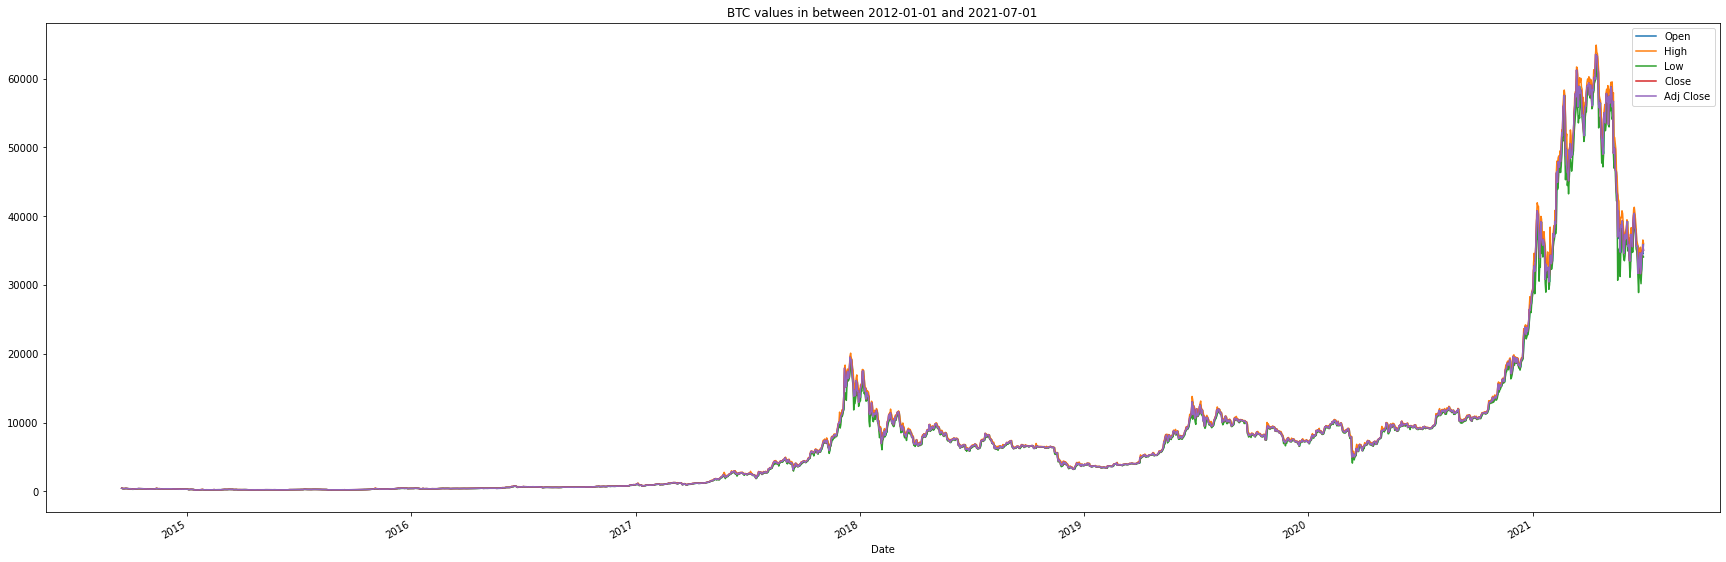

In [6]:
# To visualize the dataset better, drop "Volume"
visual_past_vals_df = past_vals_df.drop(["Volume"], axis = 1)
visual_past_vals_df.plot(title = "BTC values in between 2012-01-01 and 2021-07-01")

## Second Dataset

### Calculation

In [7]:
df = past_vals_df.copy()
close = df["Close"]
open = df["Open"]
high = df["High"]
low = df["Low"]
volume = df["Volume"]

In [8]:
# SAR
df["sar_fast"] = talib.SAR(high, low, acceleration = 0.01, maximum = 0.1)
df["sar_mid"] = talib.SAR(high, low, acceleration = 0.001, maximum = 0.1)
df["sar_slow"] = talib.SAR(high, low, acceleration = 0.0001, maximum = 0.1)

In [9]:
# RSI
rsi_period = 14

rsi = talib.RSI(close, rsi_period)
df["rsi"] = rsi

In [10]:
# MACD
macd_short_period = 12
macd_long_period = 26

macd = talib.MACD(close, macd_short_period, macd_long_period)

df["macd"], df["macd_signal"], df["macd_hist"] = macd

In [11]:
# OBV
df["OBV"] = talib.OBV(close, volume)

In [12]:
# BBANDS
df["BBANDS_upper"], df["BBANDS_middle"], df["BBANDS_lower"] = talib.BBANDS(close, matype=MA_Type.T3)

### First glance

In [13]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,sar_fast,sar_mid,sar_slow,rsi,macd,macd_signal,macd_hist,OBV,BBANDS_upper,BBANDS_middle,BBANDS_lower
Date,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21056800.0,NaN,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,468.174011,468.174011,468.174011,NaN,NaN,NaN,NaN,-13426400.0,NaN,NaN,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,467.623311,468.118941,468.168504,NaN,NaN,NaN,NaN,-51346100.0,NaN,NaN,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,465.961485,467.951767,468.151777,NaN,NaN,NaN,NaN,-14482500.0,NaN,NaN,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,464.332896,467.784928,468.135053,NaN,NaN,NaN,NaN,-41062600.0,NaN,NaN,NaN


In [14]:
df = df.dropna(axis = 0, how = 'any')
df.head()

,Open,High,Low,Close,Adj Close,Volume,sar_fast,sar_mid,sar_slow,rsi,macd,macd_signal,macd_hist,OBV,BBANDS_upper,BBANDS_middle,BBANDS_lower
Date,,,,,,,,,,,,,,,,,
2014-10-20,389.230988,390.084015,378.252014,382.845001,382.845001,16419000,312.274406,446.066690,465.832682,45.861098,-6.216836,-14.504225,8.287389,-18663162.0,399.286622,391.855516,384.424410
2014-10-21,382.420990,392.645996,380.834015,386.475006,386.475006,14188900,315.257113,444.969295,465.709106,47.337013,-5.196584,-12.642697,7.446112,-4474262.0,397.413363,390.835275,384.257187
2014-10-22,386.118011,388.575989,382.248993,383.157990,383.157990,11641300,318.150340,443.879582,465.585617,46.100267,-4.602627,-11.034683,6.432056,-16115562.0,396.213402,389.399104,382.584805
2014-10-23,382.962006,385.048004,356.446991,358.416992,358.416992,26456900,320.956770,442.797497,465.462214,38.103741,-6.058464,-10.039439,3.980975,-42572462.0,407.161166,384.945749,362.730333
2014-10-24,358.591003,364.345001,353.304993,358.345001,358.345001,15585700,323.679007,441.722986,465.338898,38.083041,-7.135779,-9.458707,2.322928,-58158162.0,404.018208,378.632824,353.247439


## Final Dataset

In [15]:
df["Close_change"] = df["Close"].pct_change()
df["Close_change_shifted"] = df["Close_change"].shift(-1)
df.drop(columns = "Close_change", inplace = True)
df.drop(df.index[-1], inplace=True)

In [16]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,sar_fast,sar_mid,sar_slow,rsi,macd,macd_signal,macd_hist,OBV,BBANDS_upper,BBANDS_middle,BBANDS_lower,Close_change_shifted
Date,,,,,,,,,,,,,,,,,,
2021-06-25,34659.105469,35487.246094,31350.884766,31637.779297,31637.779297,40230904226,40471.840458,57562.321572,64794.331194,37.622233,-1837.168944,-1649.393204,-187.775740,1.582203e+12,35585.874449,33217.514755,30849.155060,0.017337
2021-06-26,31594.664062,32637.587891,30184.501953,32186.277344,32186.277344,38585385521,40240.276071,57361.640669,64787.151052,39.260154,-1901.140304,-1699.742624,-201.397680,1.620789e+12,34960.893856,32764.095391,30567.296926,0.076535
2021-06-27,32287.523438,34656.128906,32071.757812,34649.644531,34649.644531,35511640894,40013.342972,57162.364531,64779.972346,46.104813,-1733.086974,-1706.411494,-26.675480,1.656300e+12,35185.352010,32681.868962,30178.385915,-0.006214
2021-06-28,34679.121094,35219.890625,33902.074219,34434.335938,34434.335938,33892523752,39790.948534,56964.483327,64772.795076,45.620909,-1598.846596,-1684.898514,86.051919,1.622408e+12,35518.289367,32874.252005,30230.214643,0.041628
2021-06-29,34475.558594,36542.109375,34252.484375,35867.777344,35867.777344,37901460044,39573.001985,56767.987292,64765.619241,49.426638,-1361.103434,-1620.139498,259.036064,1.660309e+12,36549.229215,33365.617630,30182.006045,-0.023055


In [17]:
up_down_list = []
for curr_index in range(len(df)):
    to_append = 1 if df["Close_change_shifted"][curr_index] > 0 else 0
    up_down_list.append(to_append)
df["direction"] = up_down_list   
df.tail(10) 

,Open,High,Low,Close,Adj Close,Volume,sar_fast,sar_mid,sar_slow,rsi,macd,macd_signal,macd_hist,OBV,BBANDS_upper,BBANDS_middle,BBANDS_lower,Close_change_shifted,direction
Date,,,,,,,,,,,,,,,,,,,
2021-06-20,35563.140625,36059.484375,33432.074219,35698.296875,35698.296875,36664034054,32430.428086,58505.782013,64822.621538,42.507182,-1197.301930,-1490.945820,293.643890,1.536838e+12,39908.777770,37450.054321,34991.330872,-0.112655,0
2021-06-21,35641.144531,35721.640625,31295.935547,31676.693359,31676.693359,52809038594,41295.269531,58338.836297,64819.250720,34.707416,-1537.507619,-1500.258180,-37.249439,1.484029e+12,40456.080644,36339.386314,32222.691983,0.026170,1
2021-06-22,31622.376953,33292.453125,28893.621094,32505.660156,32505.660156,58964353058,41195.276191,58172.892256,64815.880239,37.262861,-1720.400678,-1544.286679,-176.113999,1.542994e+12,38709.499139,35132.830997,31556.162856,0.037451,1
2021-06-23,32515.714844,34753.410156,31772.632812,33723.027344,33723.027344,46317108925,40949.243089,57967.937358,64808.695787,40.919769,-1746.975343,-1584.824412,-162.150931,1.589311e+12,37433.942583,34199.014451,30964.086318,0.027857,1
2021-06-24,33682.800781,35228.851562,32385.214844,34662.437500,34662.437500,33123368116,40708.130650,57764.417144,64801.512772,43.649413,-1672.948696,-1602.449269,-70.499427,1.622434e+12,36596.873370,33708.374298,30819.875227,-0.087260,0
2021-06-25,34659.105469,35487.246094,31350.884766,31637.779297,31637.779297,40230904226,40471.840458,57562.321572,64794.331194,37.622233,-1837.168944,-1649.393204,-187.775740,1.582203e+12,35585.874449,33217.514755,30849.155060,0.017337,1
2021-06-26,31594.664062,32637.587891,30184.501953,32186.277344,32186.277344,38585385521,40240.276071,57361.640669,64787.151052,39.260154,-1901.140304,-1699.742624,-201.397680,1.620789e+12,34960.893856,32764.095391,30567.296926,0.076535,1
2021-06-27,32287.523438,34656.128906,32071.757812,34649.644531,34649.644531,35511640894,40013.342972,57162.364531,64779.972346,46.104813,-1733.086974,-1706.411494,-26.675480,1.656300e+12,35185.352010,32681.868962,30178.385915,-0.006214,0
2021-06-28,34679.121094,35219.890625,33902.074219,34434.335938,34434.335938,33892523752,39790.948534,56964.483327,64772.795076,45.620909,-1598.846596,-1684.898514,86.051919,1.622408e+12,35518.289367,32874.252005,30230.214643,0.041628,1


In [18]:
df["Close_shifted"] = df["Close"].shift(-1)
df.drop(columns = ["Close", "Adj Close", "Close_change_shifted"], inplace = True)
df.drop(df.index[-1], inplace=True)

In [19]:
df.head()

,Open,High,Low,Volume,sar_fast,sar_mid,sar_slow,rsi,macd,macd_signal,macd_hist,OBV,BBANDS_upper,BBANDS_middle,BBANDS_lower,direction,Close_shifted
Date,,,,,,,,,,,,,,,,,
2014-10-20,389.230988,390.084015,378.252014,16419000,312.274406,446.066690,465.832682,45.861098,-6.216836,-14.504225,8.287389,-18663162.0,399.286622,391.855516,384.424410,1,386.475006
2014-10-21,382.420990,392.645996,380.834015,14188900,315.257113,444.969295,465.709106,47.337013,-5.196584,-12.642697,7.446112,-4474262.0,397.413363,390.835275,384.257187,0,383.157990
2014-10-22,386.118011,388.575989,382.248993,11641300,318.150340,443.879582,465.585617,46.100267,-4.602627,-11.034683,6.432056,-16115562.0,396.213402,389.399104,382.584805,0,358.416992
2014-10-23,382.962006,385.048004,356.446991,26456900,320.956770,442.797497,465.462214,38.103741,-6.058464,-10.039439,3.980975,-42572462.0,407.161166,384.945749,362.730333,0,358.345001
2014-10-24,358.591003,364.345001,353.304993,15585700,323.679007,441.722986,465.338898,38.083041,-7.135779,-9.458707,2.322928,-58158162.0,404.018208,378.632824,353.247439,0,347.270996


In [20]:
final_df = df.copy()

<AxesSubplot:>

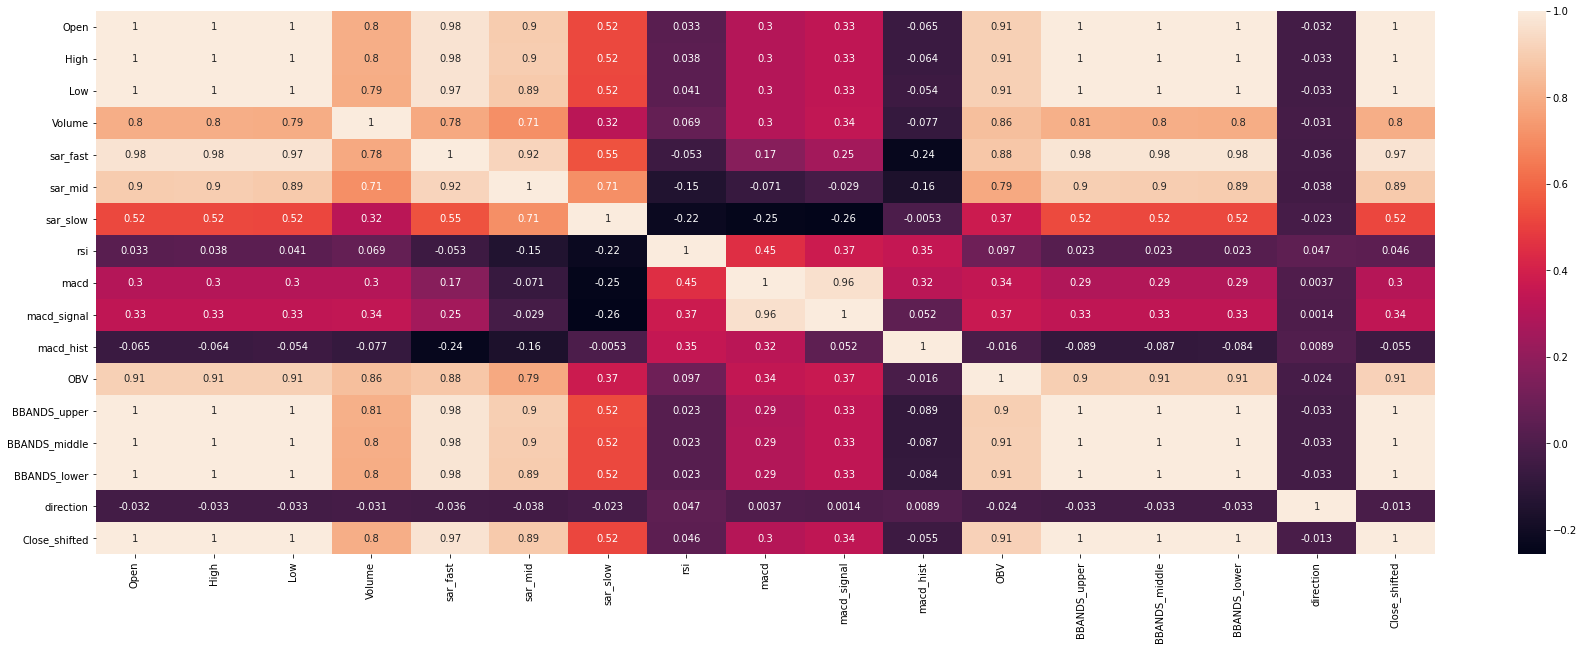

In [21]:
corr = final_df.corr()
sns.heatmap(corr, annot = True)

# MODEL TRAINING

## Arranging X and Y datasets

In [22]:
y = final_df["direction"]
X_ = final_df.drop(["direction", "Close_shifted"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.3, random_state = 123)

## Logistic Regression

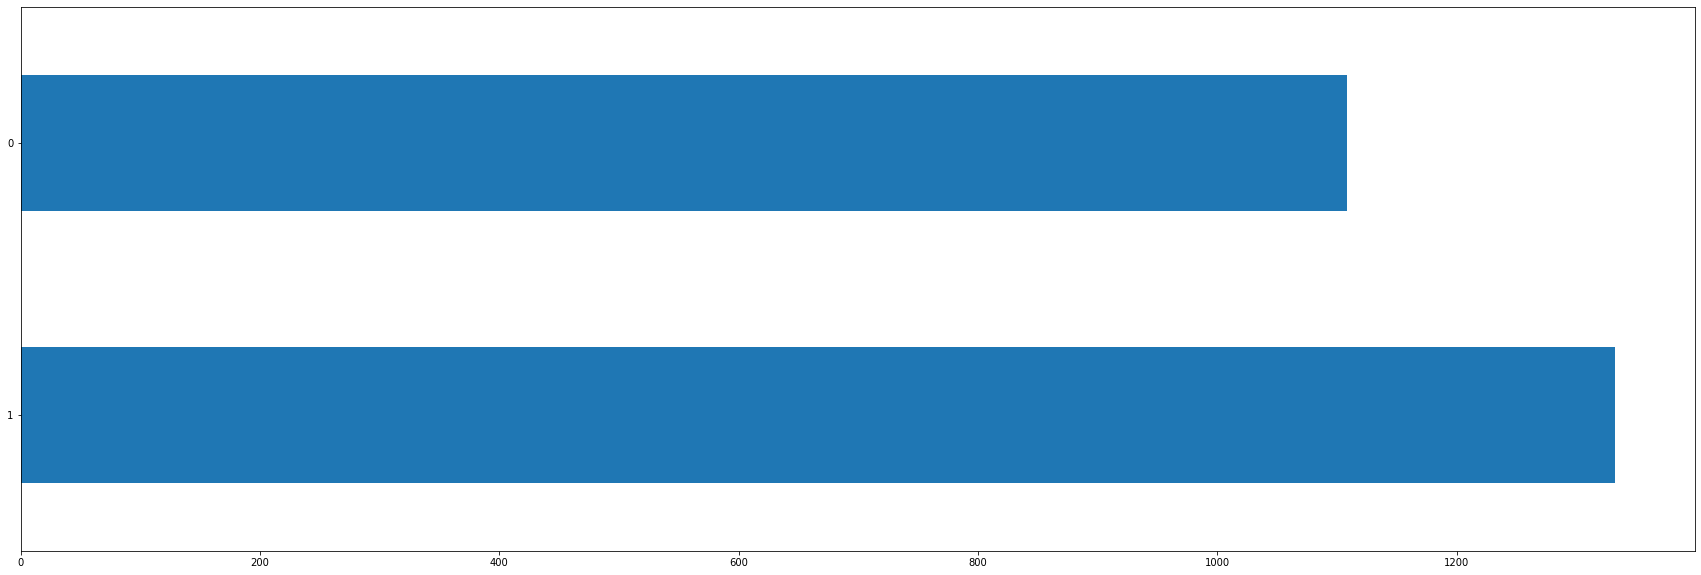

In [23]:
final_df["direction"].value_counts().plot.barh();

In [24]:
loj = LogisticRegression(solver = "liblinear")
loj_model = loj.fit(X_, y)
loj_model

LogisticRegression(solver='liblinear')

In [25]:
loj_model.coef_

array([[-1.26537380e-18, -1.57723043e-18, -1.60518473e-18,
        -1.29789384e-12, -2.49194355e-18, -1.97514675e-18,
         4.98946179e-18,  1.18351619e-19,  9.96586121e-20,
         5.55949225e-20,  4.40636896e-20,  1.26268667e-13,
        -1.89800125e-18, -1.69849454e-18, -1.49898784e-18]])

### Predictio and Success Metrics

In [26]:
y_pred_loj_model = loj_model.predict(X_)

In [27]:
confusion_matrix(y, y_pred_loj_model)

array([[ 240,  868],
       [ 251, 1081]], dtype=int64)

In [28]:
accuracy_score(y, y_pred_loj_model)

0.5413934426229509

In [29]:
print(classification_report(y, y_pred_loj_model))

              precision    recall  f1-score   support

           0       0.49      0.22      0.30      1108
           1       0.55      0.81      0.66      1332

    accuracy                           0.54      2440
   macro avg       0.52      0.51      0.48      2440
weighted avg       0.52      0.54      0.50      2440



In [30]:
# y_probs = loj_model.predict_proba(X_)[:][:,0:2]

In [31]:
# y_probs = y_probs[:,1]

In [32]:
# y_pred_loj_model = [1 if i > 0.5 else 0 for i in y_probs]

## Naive Bayes

In [33]:
nb = GaussianNB()
nb_model = nb.fit(X_train, y_train)

In [34]:
nb_model.predict(X_test)[0:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int64)

In [35]:
y_pred_nb_model = nb_model.predict(X_test)

In [36]:
accuracy_score(y_test, y_pred_nb_model)

0.5327868852459017

## KNN

In [37]:
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)

In [38]:
y_pred_knn = knn_model.predict(X_test)

In [39]:
accuracy_score(y_test, y_pred_knn)

0.51775956284153

In [40]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.47      0.44      0.45       334
           1       0.55      0.59      0.57       398

    accuracy                           0.52       732
   macro avg       0.51      0.51      0.51       732
weighted avg       0.52      0.52      0.52       732



## CART

In [41]:
cart = DecisionTreeClassifier()
cart_model = cart.fit(X_train, y_train)

In [42]:
print(skompile(cart_model.predict).to("python/code"))

(((1 if x[12] <= 227.0630874633789 else ((((0 if x[14] <= 
    171.91893768310547 else 1) if x[11] <= -163319528.0 else ((((0 if x[3] <=
    21761650.0 else 1 if x[3] <= 23683700.0 else 0 if x[0] <= 
    239.8219985961914 else 1) if x[12] <= 335.4794158935547 else 1 if x[0] <=
    336.29600524902344 else 0 if x[13] <= 349.3174285888672 else 1) if x[11
    ] <= -65853598.0 else 0) if x[9] <= -1.5095424056053162 else 1) if x[3] <=
    34538050.0 else 1 if x[11] <= 625384608.0 else 0 if x[4] <= 
    612.166259765625 else ((((((((1 if x[11] <= 154442768384.0 else 0) if x
    [12] <= 6177.237060546875 else 1) if x[1] <= 5639.418212890625 else 0) if
    x[7] <= 23.473835945129395 else (((((((((0 if x[12] <= 
    3388.554931640625 else 1) if x[10] <= -44.07706642150879 else 1) if x[7
    ] <= 33.95130920410156 else (0 if x[2] <= 567.8794860839844 else 1) if 
    x[13] <= 1702.577880859375 else 0) if x[7] <= 35.98921203613281 else 1 if
    x[9] <= -15.361851215362549 else 0 if x[9] <= -13.7061

In [43]:
y_pred_cart_model = cart_model.predict(X_test)

In [44]:
accuracy_score(y_test, y_pred_cart_model)

0.5573770491803278

## Random Forest

In [45]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train)

In [46]:
y_pred_rf_model = rf_model.predict(X_test)

In [47]:
accuracy_score(y_test, y_pred_rf_model)

0.5478142076502732

## GBM

In [48]:
gbm = GradientBoostingClassifier()
gbm_model = gbm.fit(X_train, y_train)

In [49]:
y_pred_gbm_model = gbm_model.predict(X_test)

In [50]:
accuracy_score(y_test, y_pred_gbm_model)

0.5191256830601093

## XGBoost

In [51]:
xgb = XGBClassifier()
xgb_model = xgb.fit(X_train, y_train)

[12:54:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [52]:
y_pred_xgb_model = xgb_model.predict(X_test)

In [53]:
accuracy_score(y_test, y_pred_xgb_model)

0.5136612021857924

## LightGBM

In [54]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(X_train, y_train)

In [55]:
y_pred_lgbm_model = lgbm_model.predict(X_test)

In [56]:
accuracy_score(y_test, y_pred_lgbm_model)

0.5382513661202186

## CatBoost

In [57]:
catb = CatBoostClassifier()
catb_model = catb.fit(X_train, y_train)

Learning rate set to 0.012948
0:	learn: 0.6926233	total: 160ms	remaining: 2m 39s
1:	learn: 0.6922490	total: 164ms	remaining: 1m 21s
2:	learn: 0.6917577	total: 171ms	remaining: 56.7s
3:	learn: 0.6911151	total: 177ms	remaining: 44.1s
4:	learn: 0.6905963	total: 186ms	remaining: 36.9s
5:	learn: 0.6900916	total: 192ms	remaining: 31.8s
6:	learn: 0.6895220	total: 198ms	remaining: 28s
7:	learn: 0.6891286	total: 203ms	remaining: 25.2s
8:	learn: 0.6886756	total: 209ms	remaining: 23s
9:	learn: 0.6883265	total: 214ms	remaining: 21.2s
10:	learn: 0.6879990	total: 220ms	remaining: 19.8s
11:	learn: 0.6876429	total: 224ms	remaining: 18.5s
12:	learn: 0.6871222	total: 228ms	remaining: 17.3s
13:	learn: 0.6868367	total: 232ms	remaining: 16.3s
14:	learn: 0.6865599	total: 235ms	remaining: 15.4s
15:	learn: 0.6860378	total: 239ms	remaining: 14.7s
16:	learn: 0.6856422	total: 242ms	remaining: 14s
17:	learn: 0.6854091	total: 246ms	remaining: 13.4s
18:	learn: 0.6851053	total: 249ms	remaining: 12.9s
19:	learn: 0.68

In [58]:
y_pred_catb_model = catb_model.predict(X_test)

In [59]:
accuracy_score(y_test, y_pred_catb_model)

0.5081967213114754

# MODEL SELECTION

In [60]:
loj_model_acc = accuracy_score(y, y_pred_loj_model)
nb_model_acc = accuracy_score(y_test, y_pred_nb_model)
knn_model_acc = accuracy_score(y_test, y_pred_knn)
cart_model_acc = accuracy_score(y_test, y_pred_cart_model)
rf_model_acc = accuracy_score(y_test, y_pred_rf_model)
gbm_model_acc = accuracy_score(y_test, y_pred_gbm_model)
xgb_model_acc = accuracy_score(y_test, y_pred_xgb_model)
lgbm_model_acc = accuracy_score(y_test, y_pred_lgbm_model)
catb_model_acc = accuracy_score(y_test,   y_pred_catb_model)

In [61]:
cmp_dic = {"loj_model": [loj_model_acc],
            "nb_model": [nb_model_acc],
            "knn_model": [knn_model_acc],
            "cart_model": [cart_model_acc],
            "rf_model": [rf_model_acc],
            "gbm_model": [gbm_model_acc],
            "xgb_model": [xgb_model_acc],
            "lgbm_model": [lgbm_model_acc],
            "catb_model": [catb_model_acc],}  

cmp_df = pd.DataFrame(cmp_dic, index = ["accuracy"])
cmp_df

,loj_model,nb_model,knn_model,cart_model,rf_model,gbm_model,xgb_model,lgbm_model,catb_model
accuracy,0.541393,0.532787,0.51776,0.557377,0.547814,0.519126,0.513661,0.538251,0.508197


# MODEL EVALUATION

In [62]:
# lgbm = LGBMClassifier()
# lgbm_params = {"n_estimators": [100, 500, 1000, 2000], "subsample": [0.6, 0.8, 1.0], "max_depth": [3, 4, 5, 6], "learning_rate": [0.1, 0.01, 0.02, 0.05], "min_child_samples": [5, 10, 20]}
# lgbm_cv_model = GridSearchCV(lgbm, lgbm_params, cv = 10, n_jobs = -1, verbose = 2)

In [63]:
# lgbm_cv_model.fit(X_train, y_train)

In [64]:
# lgbm_cv_model.best_params_

In [65]:
lgbm = LGBMClassifier(learning_rate = 0.1,
                        max_depth = 5,
                        subsample = 0.6,
                        n_estimators = 2000,
                        min_child_samples = 20)

In [66]:
lgbm_model_tuned = lgbm.fit(X_train, y_train)

In [67]:
y_pred_lgbm_model_tuned = lgbm_model_tuned.predict(X_test)

In [68]:
accuracy_score(y_test, y_pred_lgbm_model_tuned)

0.5191256830601093

In [69]:
print(classification_report(y_test, y_pred_lgbm_model_tuned))

              precision    recall  f1-score   support

           0       0.47      0.46      0.46       334
           1       0.56      0.57      0.56       398

    accuracy                           0.52       732
   macro avg       0.51      0.51      0.51       732
weighted avg       0.52      0.52      0.52       732



In [70]:
confusion_matrix(y_test, y_pred_lgbm_model_tuned)

array([[152, 182],
       [170, 228]], dtype=int64)

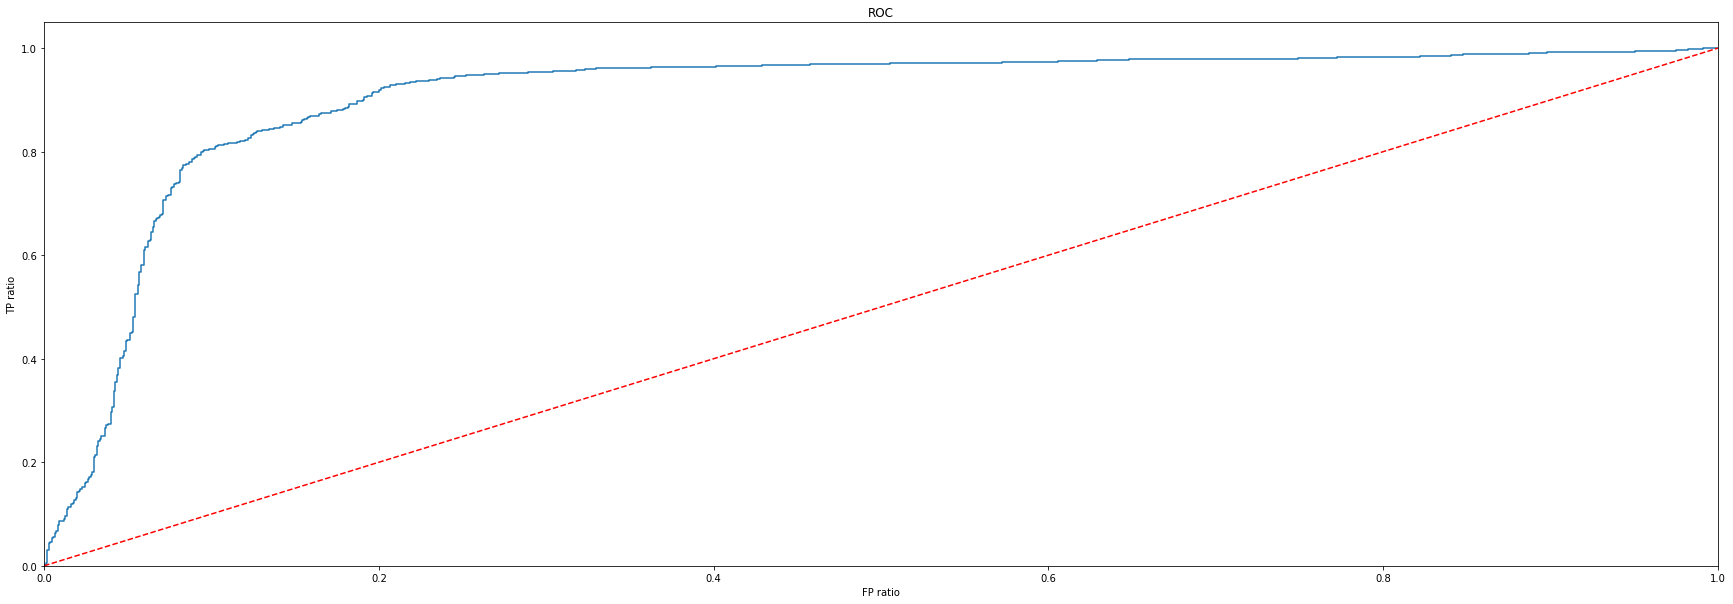

In [71]:
roc_auc = roc_auc_score(y, lgbm_model_tuned.predict(X_))
fpr, tpr, tresholds = roc_curve(y, lgbm_model_tuned.predict_proba(X_)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = "AUC (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FP ratio")
plt.ylabel("TP ratio")
plt.title("ROC")
plt.show()

In [72]:
back_test_df = pd.DataFrame()
back_test_df["Prediction"] = y_pred_lgbm_model_tuned
back_test_df["Direction"] = y_test.values
back_test_df

,Prediction,Direction
0,1,1
1,0,0
2,0,1
3,1,1
4,1,0
...,...,...
727,1,1
728,1,0
729,1,1
730,0,1


In [73]:
tp = 0
tn = 0
fp = 0
fn = 0

for curr_index in range(len(back_test_df["Direction"])):
    curr_pred = back_test_df["Prediction"].values[curr_index]
    curr_direction = back_test_df["Direction"].values[curr_index]

    if curr_direction == 1:
        if curr_pred == 1:
            tp += 1
        else:
            fn +=1
    else:
        if curr_pred == 1:
            fp += 1
        else:
            tn += 1

f1_score = tp / (tp + (fp/2 + fn/2))
print(tp, " ", fn)
print(fp, " ", tn)
print("f1_score: {0}".format(f1_score))

228   170
182   152
f1_score: 0.5643564356435643
